In [38]:
# data analysis and wrangling
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import classification_report

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Metrics Libraries
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [ ]:
dfRaw = pd.read_csv('./Data/Input.csv', delimiter = ',', nrows = 6000000)


# Encode categorical columns
df = dfRaw.copy()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert everything to float
df = df.astype(float)


dfRaw.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [40]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

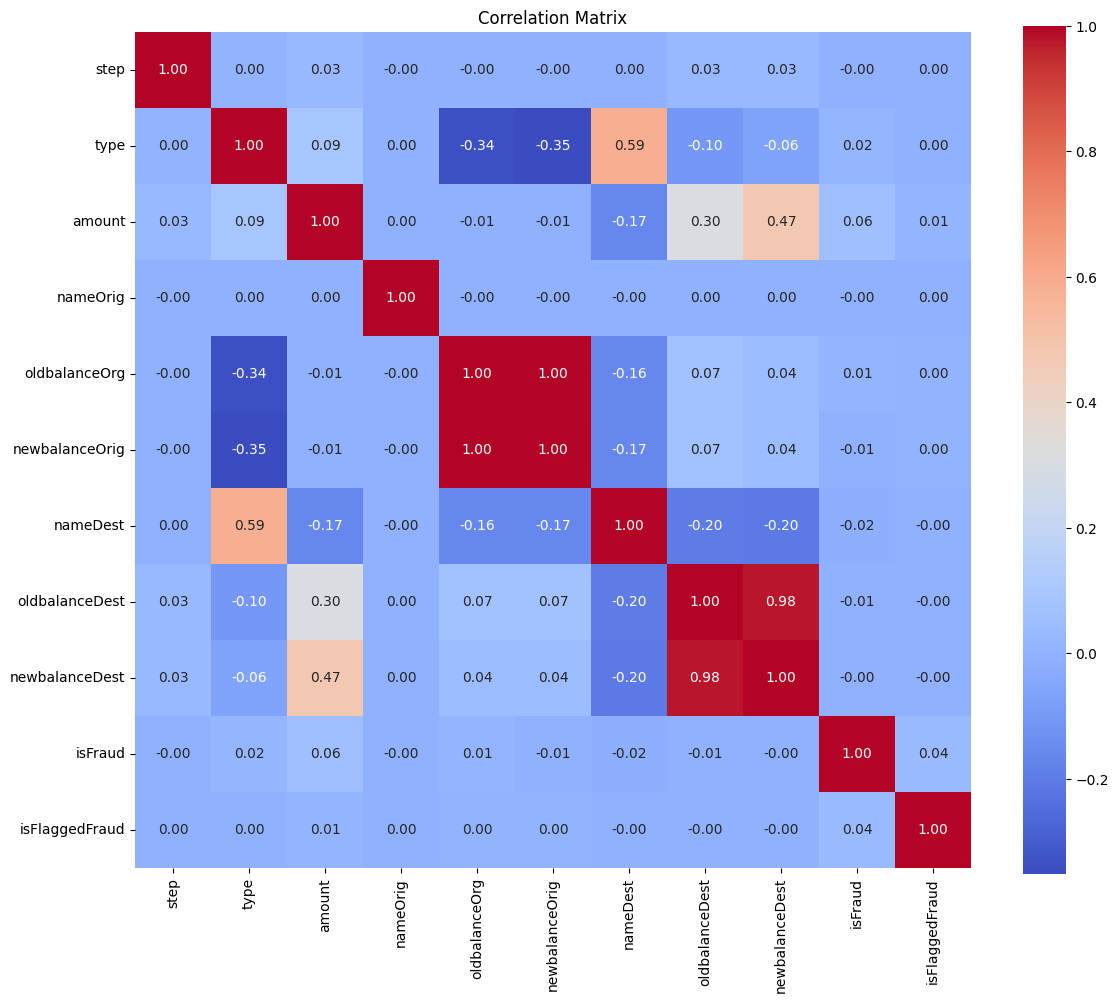

isFraud           1.000000
amount            0.058469
isFlaggedFraud    0.035286
type              0.016459
oldbalanceOrg     0.007135
newbalanceDest   -0.000057
nameOrig         -0.000196
step             -0.002458
oldbalanceDest   -0.005144
newbalanceOrig   -0.006849
nameDest         -0.017131
Name: isFraud, dtype: float64


In [41]:
plt.figure(figsize=(12, 10))

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

target_corr = corr_matrix['isFraud'].sort_values(ascending=False)
print(target_corr)

In [42]:
#preprocessing

#drop 'isFraud' from X
X = df.drop('isFraud', axis=1)
y = df['isFraud']

#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)


In [43]:
#feature engineering (maybe Ill remove the type and newbalance columns later)

df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']


In [44]:
# Scaling for unsupervised learning

X_scaled = df.drop(columns=['isFraud'])

def Standard_Scaler(df):
    scaler = StandardScaler()
    
    # Fit on data and transform
    df[col_names] = scaler.fit_transform(df[col_names])
    
    return df

col_names = ['type', 'amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
X_scaled = Standard_Scaler(X_scaled)

X_scaled.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,-1.871564,0.956017,-0.278862,714675.0,-0.229979,-0.237821,1562631.0,-0.326685,-0.335373,0.0,9839.64,0.0
1,-1.871564,0.956017,-0.291907,2064732.0,-0.280782,-0.285309,1630261.0,-0.326685,-0.335373,0.0,1864.28,0.0
2,-1.871564,1.697745,-0.294660,945114.0,-0.287971,-0.291842,412883.0,-0.326685,-0.335373,0.0,181.00,0.0
3,-1.871564,-0.527437,-0.294660,5496455.0,-0.287971,-0.291842,367799.0,-0.320374,-0.335373,0.0,181.00,-21182.0
4,-1.871564,0.956017,-0.275871,3249712.0,-0.273854,-0.281771,778780.0,-0.326685,-0.335373,0.0,11668.14,0.0


f:\ComputerStuff\Anaconda\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



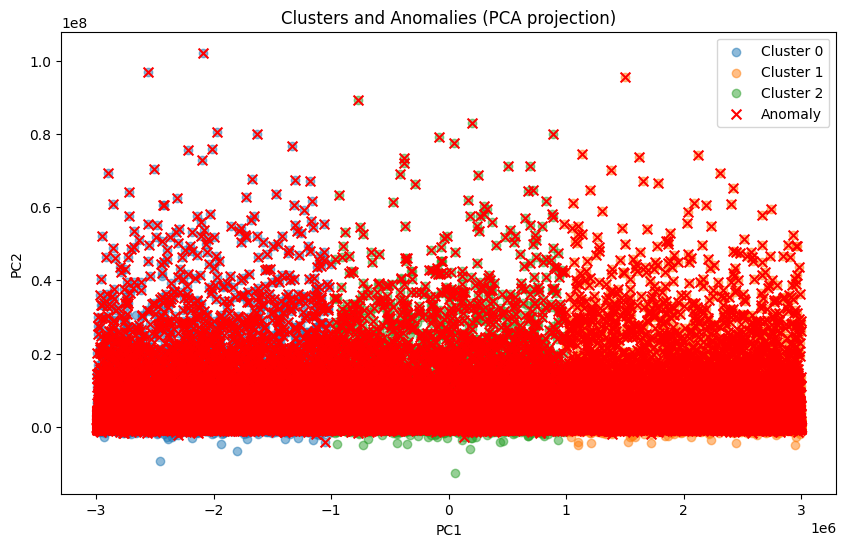

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,anomaly,cluster,PC1,PC2
4136960,303.0,4.0,29802113.19,895178.0,550210.01,0.0,138052.0,4.857447e+07,1.542623e+08,0.0,0.0,550210.01,1.056878e+08,1,0,-2.091006e+06,1.022425e+08
3892529,284.0,4.0,64234448.19,432125.0,0.00,0.0,439897.0,6.597691e+07,1.663021e+08,0.0,0.0,0.00,1.003252e+08,1,0,-2.554625e+06,9.696820e+07
3963647,297.0,4.0,23496309.32,4489369.0,0.00,0.0,455633.0,2.123595e+08,3.114049e+08,0.0,0.0,0.00,9.904545e+07,1,1,1.502501e+06,9.572609e+07
3686583,276.0,4.0,92445516.64,2216352.0,0.00,0.0,381617.0,9.595980e+03,9.245511e+07,0.0,0.0,0.00,9.244552e+07,1,2,-7.711023e+05,8.936242e+07
4131403,302.0,4.0,35894320.06,3184116.0,0.00,0.0,112937.0,1.503281e+08,2.362512e+08,0.0,0.0,0.00,8.592310e+07,1,2,1.961127e+05,8.312266e+07


In [45]:
# Unsupervised Learning with KMEans and Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = (iso.fit_predict(X_scaled) == -1).astype(int)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['cluster'] = clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Use cluster color and anomaly shape
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df['cluster'].unique()):
    cluster_mask = df['cluster'] == cluster_id
    plt.scatter(
        X_pca[cluster_mask, 0],
        X_pca[cluster_mask, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.5
    )

# Overlay anomalies (red X markers)
anomalies = df['anomaly'] == 1
plt.scatter(
    X_pca[anomalies, 0],
    X_pca[anomalies, 1],
    color='red', marker='x', label='Anomaly', s=50
)

plt.title("Clusters and Anomalies (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

df_show = df.copy()

df_show.groupby('cluster').mean(numeric_only=True)

df_show['PC1'] = X_pca[:, 0]
df_show['PC2'] = X_pca[:, 1]

df_show['anomaly'] = iso.fit_predict(X_scaled)
df_show['anomaly'] = df_show['anomaly'].map({1: 0, -1: 1})

df_show[df_show['anomaly'] == 1].sort_values(by='PC2', ascending=False).head(5)

<Figure size 1400x800 with 0 Axes>

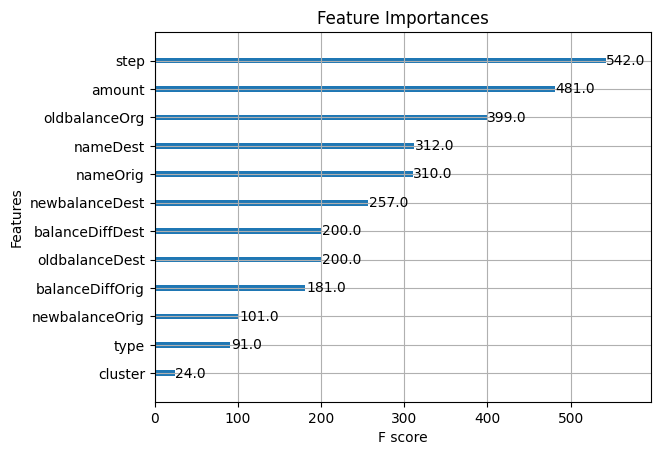

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,balanceDiffOrig,balanceDiffDest,anomaly,cluster
0,1.0,3.0,9839.64,714675.0,170136.0,160296.36,1562631.0,0.0,0.0,9839.64,0.0,0,0
1,1.0,3.0,1864.28,2064732.0,21249.0,19384.72,1630261.0,0.0,0.0,1864.28,0.0,0,2
2,1.0,4.0,181.00,945114.0,181.0,0.00,412883.0,0.0,0.0,181.00,0.0,0,0
3,1.0,1.0,181.00,5496455.0,181.0,0.00,367799.0,21182.0,0.0,181.00,-21182.0,0,1
4,1.0,3.0,11668.14,3249712.0,41554.0,29885.86,778780.0,0.0,0.0,11668.14,0.0,0,2


In [46]:
# Making sets for supervised learning, using the feature importances and the new cluster column

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

# Determine the importance of each feature
model_xgb = xgb.XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

# Set the figure size before plotting
plt.figure(figsize=(14, 8))
xgb.plot_importance(model_xgb, importance_type='weight', max_num_features=12, title='Feature Importances')
plt.show()

X.head(5)

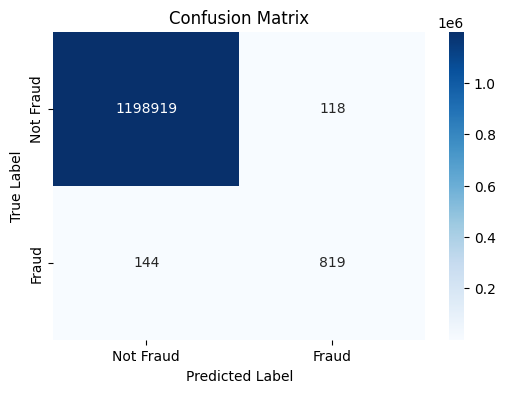

Random Forest Classifier Accuracy: [0.99980729 0.99981042 0.99979583 0.99978958 0.99980521]
Cross Validation Recall scores are: [0.85844156 0.84545455 0.83506494 0.84435798 0.85732815]
Average Cross Validation Recall score: 0.8481294321761249
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1199037
       Fraud       0.87      0.85      0.86       963

    accuracy                           1.00   1200000
   macro avg       0.94      0.93      0.93   1200000
weighted avg       1.00      1.00      1.00   1200000



In [47]:
#training without sampling

kf = StratifiedKFold(n_splits=5, shuffle=False)

model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=99/1,
    tree_method='hist',
    device = 'cuda',
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

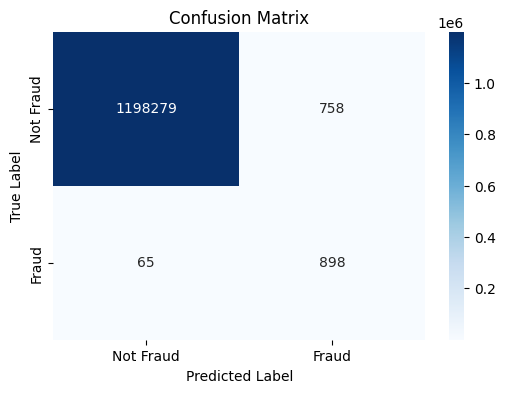

Random Forest Classifier Accuracy: [0.99936563 0.99936979 0.999275   0.99934375 0.99933125]
Cross Validation Recall scores are: [0.93506494 0.92337662 0.92857143 0.93904021 0.94422827]
Average Cross Validation Recall score: 0.9340562939006519
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1199037
       Fraud       0.54      0.93      0.69       963

    accuracy                           1.00   1200000
   macro avg       0.77      0.97      0.84   1200000
weighted avg       1.00      1.00      1.00   1200000



In [48]:
#training with SMOTE (with optimal parameters)

from imblearn.over_sampling import SMOTE

kf = StratifiedKFold(n_splits=5, shuffle=False)

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=13)),
    ('model', xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.05,
    #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    tree_method='hist',
    device = 'cuda',
    eval_metric='aucpr',
    random_state=42
    ))
])
#the weights should be around 1:6-1:7
#rf = RandomForestClassifier(n_estimators=1000, random_state=13, max_depth=10, class_weight={0: 1, 1: 6})
#rf.fit(X_train_resampled, y_train_resampled)

pipeline.fit(X_train, y_train)
Y_pred = pipeline.predict(X_test)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

In [49]:
# Hyperparameter grid to optimize recall
'''
rf = RandomForestClassifier(random_state=13)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

grid_search = GridSearchCV(rf, param_grid, scoring='recall', cv=5, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best parameters found:", grid_search.best_params_)
# Best parameters found: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'n_estimators': 500} n can be more
# Dont use this for now, it takes too long to run, so only run as one cell


best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

scoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))
'''

'\nrf = RandomForestClassifier(random_state=13)\n\nparam_grid = {\n    \'n_estimators\': [100, 200, 500],\n    \'max_depth\': [None, 10, 20],\n    \'class_weight\': [\'balanced\', {0: 1, 1: 10}]\n}\n\ngrid_search = GridSearchCV(rf, param_grid, scoring=\'recall\', cv=5, verbose=2)\ngrid_search.fit(X_train_resampled, y_train_resampled)\n\n# Best parameters\nprint("Best parameters found:", grid_search.best_params_)\n# Best parameters found: {\'class_weight\': {0: 1, 1: 10}, \'max_depth\': 10, \'n_estimators\': 500} n can be more\n# Dont use this for now, it takes too long to run, so only run as one cell\n\n\nbest_rf = grid_search.best_estimator_\ny_pred = best_rf.predict(X_test)\n\nscoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring=\'accuracy\')\nscoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring=\'recall\')\n\ncm = confusion_matrix(y_test, Y_pred)\n\nplt.figure(figsize=(6, 4))\nsns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"],